# 1. Цель лабораторной работы:

Изучение разработки рекомендательных моделей

# 2. Задание:

1.Выбрать произвольный набор данных (датасет), предназначенный для построения рекомендательных моделей.

2.Опираясь на материалы лекции, сформировать рекомендации для одного пользователя (объекта) двумя произвольными способами.

3.Сравнить полученные рекомендации (если это возможно, то с применением метрик).

# 3. Ход выполнения работы

Импорт библиотек

In [111]:
import numpy as np
import pandas as pd
from typing import Dict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from surprise import SVD, Dataset, Reader
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
%matplotlib inline 
sns.set(style="ticks")

Чтение данных

In [112]:
df_movies_all=pd.read_csv('movies.csv')
df_movies_all.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [113]:
df_movies_all.shape

(9742, 3)

In [114]:
df_ratings=pd.read_csv('ratings.csv')
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [115]:
df_ratings.shape

(100836, 4)

In [116]:
# Оставляем только аниме, которые есть в df_rating
movie_ids = df_ratings[df_ratings['movieId'].notnull()]['movieId']
df_movie = df_movies_all[df_movies_all['movieId'].isin(movie_ids)]

In [117]:
df_movies_all.shape,df_movie.shape

((9742, 3), (9724, 3))

Выбор идентификаторов для связи таблиц

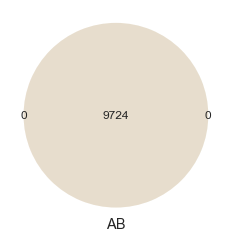

In [119]:
venn2([set(df_ratings['movieId'].unique()), set(df_movie['movieId'].unique())])

Векторизация описания фильмов

In [120]:
df_movie_with_genre = df_movie[df_movie['genres'].notnull()]
df_movie_with_genre = df_movie_with_genre[~df_movie_with_genre['genres'].str.isspace()]

In [121]:
movieId=df_movie_with_genre['movieId'].values
movieId[0:5]

array([1, 2, 3, 4, 5], dtype=int64)

In [122]:
moviename=df_movie_with_genre['title'].values
moviename[0:5]

array(['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)',
       'Waiting to Exhale (1995)', 'Father of the Bride Part II (1995)'],
      dtype=object)

In [123]:
genre=df_movie_with_genre['genres'].values
genre[0:5]

array(['Adventure|Animation|Children|Comedy|Fantasy',
       'Adventure|Children|Fantasy', 'Comedy|Romance',
       'Comedy|Drama|Romance', 'Comedy'], dtype=object)

In [124]:
%%time
tfidfv = TfidfVectorizer()
genre_matrix = tfidfv.fit_transform(genre)
genre_matrix

Wall time: 71 ms


<9724x24 sparse matrix of type '<class 'numpy.float64'>'
	with 23179 stored elements in Compressed Sparse Row format>

3.1 Фильтрация на основе содержания

Рекомендации в зависимости от жанров аниме

In [125]:
class SimpleKNNRecommender:
    
    def __init__(self, X_matrix, X_ids, X_name, X_genre):
    # Входные параметры:
    # X_matrix - обучающая выборка (матрица объект-признак)
    # X_ids - массив идентификаторов 
    # X_name - массив названий 
    # X_genre - массив жанров 

        self._X_matrix = X_matrix
        self.df = pd.DataFrame(
            {'id': pd.Series(X_ids, dtype='int'),
            'name': pd.Series(X_name, dtype='str'),
            'genre': pd.Series(X_genre, dtype='str'),
            'dist': pd.Series([], dtype='float')})
            
            
    def recommend_for_single_object(self, K: int, \
                X_matrix_object, cos_flag = True, manh_flag = False):
    # Метод формирования рекомендаций для одного объекта.
    # Входные параметры:
    # K - количество рекомендуемых соседей 
    # X_matrix_object - строка матрицы объект-признак, соответствующая объекту
    # cos_flag - флаг вычисления косинусного расстояния
    # manh_flag - флаг вычисления манхэттэнского расстояния
    # Возвращаемое значение: K найденных соседей
 
        scale = 1000000
        # Вычисляем косинусную близость
        if cos_flag:
            dist = cosine_similarity(self._X_matrix, X_matrix_object)
            self.df['dist'] = dist * scale
            res = self.df.sort_values(by='dist', ascending=False)
            # Не учитываем рекомендации с единичным расстоянием,
            # так как это искомый объект
            res = res[res['dist'] < scale]
        
        else:
            if manh_flag:
                dist = manhattan_distances(self._X_matrix, X_matrix_object)
            else:
                dist = euclidean_distances(self._X_matrix, X_matrix_object)
            self.df['dist'] = dist * scale
            res = self.df.sort_values(by='dist', ascending=True)
            # Не учитываем рекомендации с единичным расстоянием,
            # так как это искомый объект
            res = res[res['dist'] > 0.0]            
        
        # Оставляем К первых рекомендаций
        res = res.head(K)
        return res

In [126]:
Toy_Story  = 0
moviename[Toy_Story]

'Toy Story (1995)'

In [127]:
genre[Toy_Story]

'Adventure|Animation|Children|Comedy|Fantasy'

In [128]:
Toy_Story_matrix=genre_matrix[Toy_Story]
Toy_Story_matrix

<1x24 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [129]:
skr1 = SimpleKNNRecommender(genre_matrix, movieId, moviename, genre)

In [130]:
rec1 = skr1.recommend_for_single_object(15, Toy_Story_matrix)
rec1

,id,name,genre,dist
8882,134853,Inside Out (2015),Adventure|Animation|Children|Comedy|Drama|Fantasy,970751.211229
4418,6536,Sinbad: Legend of the Seven Seas (2003),Adventure|Animation|Children|Fantasy,963553.054623
5673,27731,"Cat Returns, The (Neko no ongaeshi) (2002)",Adventure|Animation|Children|Fantasy,963553.054623
1576,2116,"Lord of the Rings, The (1978)",Adventure|Animation|Children|Fantasy,963553.054623
9351,162578,Kubo and the Two Strings (2016),Adventure|Animation|Children|Fantasy,963553.054623
1504,2033,"Black Cauldron, The (1985)",Adventure|Animation|Children|Fantasy,963553.054623
6927,65261,Ponyo (Gake no ue no Ponyo) (2008),Adventure|Animation|Children|Fantasy,963553.054623
4009,5672,Pokemon 4 Ever (a.k.a. Pokémon 4: The Movie) (...,Adventure|Animation|Children|Fantasy,963553.054623
3225,4366,Atlantis: The Lost Empire (2001),Adventure|Animation|Children|Fantasy,963553.054623
2536,3400,We're Back! A Dinosaur's Story (1993),Adventure|Animation|Children|Fantasy,963553.054623


In [131]:
rec2 = skr1.recommend_for_single_object(15, Toy_Story_matrix, cos_flag = False)
rec2

,id,name,genre,dist
8882,134853,Inside Out (2015),Adventure|Animation|Children|Comedy|Drama|Fantasy,241862.724582
1576,2116,"Lord of the Rings, The (1978)",Adventure|Animation|Children|Fantasy,269988.686345
5611,27186,Kirikou and the Sorceress (Kirikou et la sorci...,Adventure|Animation|Children|Fantasy,269988.686345
5077,8015,"Phantom Tollbooth, The (1970)",Adventure|Animation|Children|Fantasy,269988.686345
9526,172793,Vovka in the Kingdom of Far Far Away (1965),Adventure|Animation|Children|Fantasy,269988.686345
1504,2033,"Black Cauldron, The (1985)",Adventure|Animation|Children|Fantasy,269988.686345
9351,162578,Kubo and the Two Strings (2016),Adventure|Animation|Children|Fantasy,269988.686345
4009,5672,Pokemon 4 Ever (a.k.a. Pokémon 4: The Movie) (...,Adventure|Animation|Children|Fantasy,269988.686345
3331,4519,"Land Before Time, The (1988)",Adventure|Animation|Children|Fantasy,269988.686345
3225,4366,Atlantis: The Lost Empire (2001),Adventure|Animation|Children|Fantasy,269988.686345


In [132]:
rec3 = skr1.recommend_for_single_object(15, Toy_Story_matrix, 
                                        cos_flag = False, manh_flag = True)
rec3

,id,name,genre,dist
8882,134853,Inside Out (2015),Adventure|Animation|Children|Comedy|Drama|Fantasy,304097.339211
9526,172793,Vovka in the Kingdom of Far Far Away (1965),Adventure|Animation|Children|Fantasy,340177.899954
5077,8015,"Phantom Tollbooth, The (1970)",Adventure|Animation|Children|Fantasy,340177.899954
2536,3400,We're Back! A Dinosaur's Story (1993),Adventure|Animation|Children|Fantasy,340177.899954
1504,2033,"Black Cauldron, The (1985)",Adventure|Animation|Children|Fantasy,340177.899954
3331,4519,"Land Before Time, The (1988)",Adventure|Animation|Children|Fantasy,340177.899954
4418,6536,Sinbad: Legend of the Seven Seas (2003),Adventure|Animation|Children|Fantasy,340177.899954
9351,162578,Kubo and the Two Strings (2016),Adventure|Animation|Children|Fantasy,340177.899954
5611,27186,Kirikou and the Sorceress (Kirikou et la sorci...,Adventure|Animation|Children|Fantasy,340177.899954
3225,4366,Atlantis: The Lost Empire (2001),Adventure|Animation|Children|Fantasy,340177.899954


Как видите, все три метода вычисления расстояний дают правильные результаты. Рекомендуемые фильмы содержат ключевое слово того же типа.

3.2 Коллаборативная фильтрация

In [133]:
len(df_ratings['userId'].unique())# Количество уникальных пользователей

610

In [134]:
len(df_ratings['movieId'].unique())# Количество уникальных аниме

9724

In [135]:
def create_utility_matrix(data):
    itemField = 'movieId'
    userField = 'userId'
    valueField = 'rating'  
    
    userList = data[userField].tolist()
    itemList = data[itemField].tolist()
    valueList = data[valueField].tolist()    
    
    users = list(set(userList))
    items = list(set(itemList))    
    
    users_index = {users[i]: i for i in range(len(users))}    
    pd_dict = {item: [0.0 for i in range(len(users))] for item in items}    
    
    for i in range(0,data.shape[0]):
        item = itemList[i]
        user = userList[i]
        value = valueList[i]    
        pd_dict[item][users_index[user]] = value    
    
    X = pd.DataFrame(pd_dict)
    X.index = users
        
    itemcols = list(X.columns)
    items_index = {itemcols[i]: i for i in range(len(itemcols))}
    
    return X, users_index, items_index

In [136]:
%%time
user_item_matrix, users_index, items_index = create_utility_matrix(df_ratings)

Wall time: 1.02 s


In [137]:
user_item_matrix

,1,2,3,4,5,6,7,8,9,10,...,98239,98243,131013,131023,32728,163809,98279,32743,65514,98296
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
609,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Посмотрите, как пользователи оценили фильм 《Toy_Story》

In [138]:
print(df_ratings.loc[df_ratings['movieId']==1,['userId','rating']])

       userId  rating
0           1     4.0
516         5     4.0
874         7     4.5
1434       15     2.5
1667       17     4.5
...       ...     ...
97364     606     2.5
98479     607     4.0
98666     608     2.5
99497     609     3.0
99534     610     5.0

[215 rows x 2 columns]


Выбрать пользователей, которые дали 5 баллов для «Toy_Story», в качестве тестовых объектов для рекомендательной системы.
Выбрать user_id = 610

In [139]:
user_item_matrix__test = user_item_matrix.loc[[610]]
user_item_matrix__test

,1,2,3,4,5,6,7,8,9,10,...,98239,98243,131013,131023,32728,163809,98279,32743,65514,98296
610,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0


In [140]:
user_item_matrix__train = user_item_matrix.loc[:609]
user_item_matrix__train

,1,2,3,4,5,6,7,8,9,10,...,98239,98243,131013,131023,32728,163809,98279,32743,65514,98296
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,4.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Построение модели на основе SVD

In [141]:
%%time
U, S, VT = np.linalg.svd(user_item_matrix__train.T)
V = VT.T

Wall time: 3.82 s


In [142]:
U.shape# 用户和潜在因素之间的关系矩阵

(9724, 9724)

In [143]:
V.shape# 对象和潜在因素之间的关系矩阵

(609, 609)

In [144]:
S.shape

(609,)

In [145]:
Sigma = np.diag(S)# 对角奇异值矩阵
Sigma.shape

(609, 609)

In [146]:
Sigma

array([[529.4937201 ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        , 227.50885376,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        , 190.53715518, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   3.87425933,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          3.11412817,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   2.9480028 ]])

In [147]:
r=3
Ur = U[:, :r]
Sr = Sigma[:r, :r]
Vr = V[:, :r]

In [148]:
# 新用户和潜在因素之间的关系矩阵
test_user = np.mat(user_item_matrix__test.values)
test_user.shape, test_user

((1, 9724), matrix([[5., 0., 0., ..., 0., 4., 0.]]))

In [149]:
tmp = test_user * Ur * np.linalg.inv(Sr)
tmp

matrix([[-0.13331135,  0.15981166, -0.0692074 ]])

In [150]:
test_user_result = np.array([tmp[0,0], tmp[0,1], tmp[0,2]])
test_user_result

array([-0.13331135,  0.15981166, -0.0692074 ])

In [151]:
cos_sim = cosine_similarity(Vr, test_user_result.reshape(1, -1))
cos_sim[:10]

array([[-0.15984579],
       [ 0.81159541],
       [-0.14714827],
       [-0.13610433],
       [-0.44311623],
       [-0.47390031],
       [ 0.48528426],
       [-0.41232427],
       [ 0.78471551],
       [ 0.8713775 ]])

In [152]:
cos_sim_list = cos_sim.reshape(-1, cos_sim.shape[0])[0]
cos_sim_list[:10]

array([-0.15984579,  0.81159541, -0.14714827, -0.13610433, -0.44311623,
       -0.47390031,  0.48528426, -0.41232427,  0.78471551,  0.8713775 ])

In [153]:
recommended_user_id = np.argsort(-cos_sim_list)[0]
recommended_user_id

317

In [154]:
df_movie

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [155]:
movie_list = list(user_item_matrix.columns)
def movie_recommend(ind):
    try:
        movie_id = movie_list[ind]
        flt_rating = df_ratings[df_ratings['movieId'] == movie_id ]
        rating = flt_rating['movieId'].values[0]
        moive_rating = df_movie[df_movie['movieId'] == rating]
        res = moive_rating['title'].values[0]
        return res
    except:
        return '' 

In [156]:
# Аниме, которые оценивал текущий пользователь user_id=152:
i=1
for idx, item in enumerate(np.ndarray.flatten(np.array(test_user))):
    if item > 0:
        movie_name = movie_recommend(idx)
        print('{} - {} - {}'.format(idx,movie_name, item))
        if i==20:
            break
        else:
            i+=1

0 - Toy Story (1995) - 5.0
5 - Heat (1995) - 5.0
15 - Casino (1995) - 4.5
31 - Twelve Monkeys (a.k.a. 12 Monkeys) (1995) - 4.5
46 - Seven (a.k.a. Se7en) (1995) - 5.0
49 - Usual Suspects, The (1995) - 4.0
69 - From Dusk Till Dawn (1996) - 4.0
92 - Broken Arrow (1996) - 3.5
107 - Braveheart (1995) - 4.5
108 - Taxi Driver (1976) - 5.0
109 - Rumble in the Bronx (Hont faan kui) (1995) - 4.0
132 - 31 (2016) - 3.5
142 - Batman Forever (1995) - 3.0
148 - Clockers (1995) - 3.5
182 - Smoke (1995) - 5.0
185 - Fearless Hyena, The (Xiao quan guai zhao) (1979) - 3.0
203 - Before Sunrise (1995) - 5.0
218 - Dumb & Dumber (Dumb and Dumber) (1994) - 4.0
225 - Hitchhiker's Guide to the Galaxy, The (2005) - 3.5
247 - Star Wars: Episode IV - A New Hope (1977) - 5.0


In [157]:
# Аниме, которые оценивал наиболее схожий пользователь:
i=1
recommended_user_item_matrix = user_item_matrix.loc[[recommended_user_id+1]]
for idx, item in enumerate(np.ndarray.flatten(np.array(recommended_user_item_matrix))):
    if item > 0:
        movie_name = movie_recommend(idx)
        print('{} - {} - {}'.format(idx, movie_name, item))
        if i==20:
            break
        else:
            i+=1

1 - Jumanji (1995) - 3.5
5 - Heat (1995) - 4.0
17 - Four Rooms (1995) - 3.0
18 - Ace Ventura: When Nature Calls (1995) - 3.5
28 - City of Lost Children, The (Cité des enfants perdus, La) (1995) - 3.5
31 - Twelve Monkeys (a.k.a. 12 Monkeys) (1995) - 4.5
46 - Seven (a.k.a. Se7en) (1995) - 4.0
47 - Pocahontas (1995) - 3.5
71 - Kicking and Screaming (1995) - 4.5
93 - Battle in Seattle (2007) - 4.0
94 - Hate (Haine, La) (1995) - 4.5
106 - Timecrimes (Cronocrímenes, Los) (2007) - 3.5
119 - Chungking Express (Chung Hing sam lam) (1994) - 4.5
125 - Trip to the Moon, A (Voyage dans la lune, Le) (1902) - 3.0
129 - Ascent, The (Voskhozhdeniye) (1977) - 3.5
134 - Bad Boys (1995) - 3.5
142 - Batman Forever (1995) - 3.0
143 - Beauty of the Day (Belle de jour) (1967) - 3.0
148 - Clockers (1995) - 4.0
151 - Crumb (1994) - 3.5
